In [1]:
import cairo
import cv2
from math import pi
import random
import math
from PIL import Image
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics

In [2]:
def polar_to_cart(theta, dist):
    
    x = 1 + dist * math.cos(theta)
    y = 1 + dist * math.sin(theta)
    
    return x,y

t = math.pi/180.0

def remap(old_val, old_min, old_max, new_min, new_max):
    return (new_max - new_min)*(old_val - old_min) / (old_max - old_min) + new_min

def draw(geno):
    
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 100, 100)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.Antialias.NONE)
    ctx.scale(50, 50)
    # Paint the background
    ctx.set_source_rgb(0, 0 , 0)
    ctx.paint()

    r1 = remap(geno[8], 0, 1,0.1, 1)
    r2 = remap(geno[9], 0, 1,0.1, 1)
    r3 = remap(geno[10], 0, 1,0.1, 1)
    r4 = remap(geno[11], 0, 1,0.1, 1)
    r5 = remap(geno[12], 0, 1,0.1, 1)
    r6 = remap(geno[13], 0, 1,0.1, 1)
    r7 = remap(geno[14], 0, 1,0.1, 1)
    r8 = remap(geno[15], 0, 1,0.1, 1)

    # Draw the image
    firstx, firsty = polar_to_cart((0 + geno[0])*45*t, r1)
    secondx, secondy = polar_to_cart((1 + geno[1])*45*t, r2)
    thirdx, thirdy = polar_to_cart((2 + geno[2])*45*t, r3)
    forthx, forthy = polar_to_cart((3 + geno[3])*45*t, r4)
    fifthx, fifthy = polar_to_cart((4 + geno[4])*45*t, r5)
    sixthx, sixthy = polar_to_cart((5 + geno[5])*45*t, r6)
    seventhx, seventhy = polar_to_cart((6 + geno[6])*45*t, r7)
    eigthx, eigthy = polar_to_cart((7 + geno[7])*45*t, r8)
    ctx.move_to(firstx, firsty)

    ctx.line_to(secondx, secondy)
    ctx.line_to(thirdx, thirdy)
    ctx.line_to(forthx, forthy)
    ctx.line_to(fifthx, fifthy)
    ctx.line_to(sixthx, sixthy)
    ctx.line_to(seventhx, seventhy)
    ctx.line_to(eigthx, eigthy)
    
    ctx.close_path()
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill_preserve()
    

    return surface

Estimated number of clusters: 3
Estimated number of noise points: 47


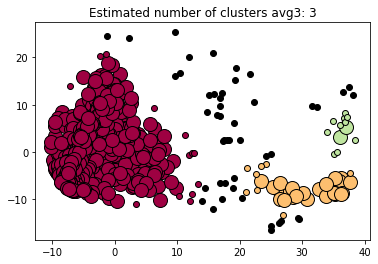

GENOTYPE
Estimated number of clusters: 4
Estimated number of noise points: 75


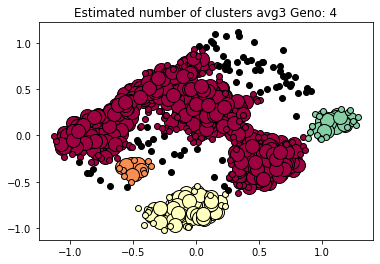

In [3]:
def load_data(filename, dim,dim_x):
    print("Loading ",filename)
    data = np.loadtxt(filename)
    fit = data[:, 0:1]
    cent = data[:,1: dim+1]
    desc = data[:,dim+1: 2*dim+1]
    x = data[:,2*dim+1:2*dim+1+dim_x]
    
def load_centroids(filename):
    points = np.loadtxt(filename)
    return points


centroids_avg3 = load_centroids("centroids_avg3.dat")
data_avg3 = np.loadtxt("archive_avg3.dat")
fit_avg3 = data_avg3[:,0:1]
geno_avg3 = data_avg3[:, 5: 21]
all_imgs_avg3 = []
for j in range(0, fit_avg3.shape[0]):    
    img1 = draw(geno_avg3[j])
    imgP1 = Image.frombuffer("RGBA",( img1.get_width(),img1.get_height() ),img1.get_data(),"raw","RGBA",0,1)
    img_arr1 = np.array(imgP1)
    flat1 = img_arr1[:,:,0].flatten()
    all_imgs_avg3.append(flat1)    
    
all_imgs_avg3 /= np.max(all_imgs_avg3)
#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg3 = t_sne.fit_transform(all_imgs_avg3)
#embed_avg3 = embed_avg3 / np.max(embed_avg3)
#print(all_imgs_avg3.shape)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_imgs_avg3)
#print(np.min(pca_results))
#print(np.max(pca_results))
#print(pca_results)




#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg3 = t_sne.fit_transform(pca_results)
embed_avg3 = pca_results
#embed_avg3 /= np.max(embed_avg3)
#print(embed_avg3)
#embed_avg3 = embed_avg3 / np.max(embed_avg7)

db = DBSCAN(eps=4, min_samples=10).fit(embed_avg3)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_avg3[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_avg3[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters avg3: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_AVG3.png', dpi=200) 
plt.show()



#GENOTYPE

print("GENOTYPE")

pca = PCA(n_components=2)
pca_results_geno = pca.fit_transform(geno_avg3)
#print(pca_results)


#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg3 = t_sne.fit_transform(pca_results)
embed_avg3_geno = pca_results_geno
#embed_avg3_geno /= np.max(embed_avg3_geno)
#print(embed_avg3_geno)
#embed_avg3 = embed_avg3 / np.max(embed_avg7)

db = DBSCAN(eps=0.13, min_samples=15).fit(embed_avg3_geno)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_avg3_geno[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_avg3_geno[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters avg3 Geno: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_AVG3_Geno.png', dpi=200) 
plt.show()


Estimated number of clusters: 2
Estimated number of noise points: 38


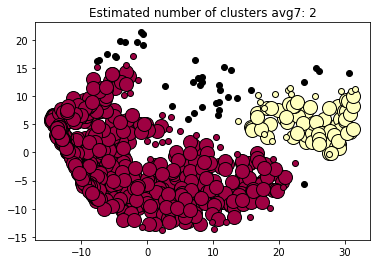

GENOTYPE
Estimated number of clusters: 4
Estimated number of noise points: 31


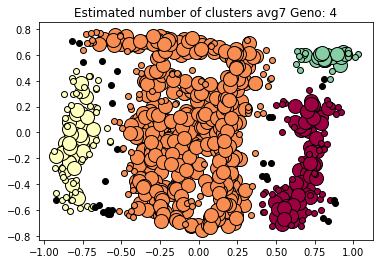

In [125]:
centroids_avg7 = load_centroids("centroids_avg7.dat")
data_avg7 = np.loadtxt("archive_avg7.dat")
fit_avg7 = data_avg7[:,0:1]
geno_avg7 = data_avg7[:, 5: 21]
all_imgs_avg7 = []
for j in range(0, fit_avg7.shape[0]):    
    img1 = draw(geno_avg7[j])
    imgP1 = Image.frombuffer("RGBA",( img1.get_width(),img1.get_height() ),img1.get_data(),"raw","RGBA",0,1)
    img_arr1 = np.array(imgP1)
    flat1 = img_arr1[:,:,0].flatten()
    all_imgs_avg7.append(flat1)    
    
all_imgs_avg7 /= np.max(all_imgs_avg7)
#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg7 = t_sne.fit_transform(all_imgs_avg7)
#embed_avg7 = embed_avg7 / np.max(embed_avg7)
#print(all_imgs_avg7.shape)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_imgs_avg7)
#print(np.min(pca_results))
#print(np.max(pca_results))
#print(pca_results)




#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg7 = t_sne.fit_transform(pca_results)
embed_avg7 = pca_results
#embed_avg7 /= np.max(embed_avg7)
#print(embed_avg7)
#embed_avg7 = embed_avg7 / np.max(embed_avg7)

db = DBSCAN(eps=3, min_samples=10).fit(embed_avg7)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_avg7[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_avg7[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters avg7: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_AVG7.png', dpi=200)
plt.show()



#GENOTYPE

print("GENOTYPE")

pca = PCA(n_components=2)
pca_results_geno = pca.fit_transform(geno_avg7)
#print(pca_results)


#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_avg7 = t_sne.fit_transform(pca_results)
embed_avg7_geno = pca_results_geno
#embed_avg7_geno /= np.max(embed_avg7_geno)
#print(embed_avg7_geno)
#embed_avg7 = embed_avg7 / np.max(embed_avg7)

db = DBSCAN(eps=0.13, min_samples=15).fit(embed_avg7_geno)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_avg7_geno[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_avg7_geno[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters avg7 Geno: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_AVG7_Geno.png', dpi=200)
plt.show()

Estimated number of clusters: 4
Estimated number of noise points: 80


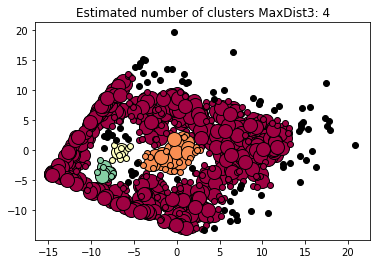

GENOTYPE
Estimated number of clusters: 5
Estimated number of noise points: 25


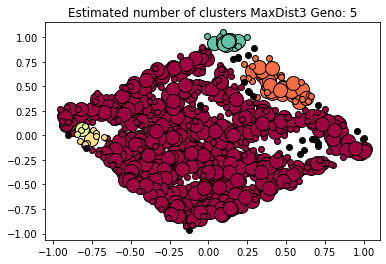

In [126]:
centroids_myversion3 = load_centroids("centroids_myversion3.dat")
data_myversion3 = np.loadtxt("archive_myversion3.dat")
fit_myversion3 = data_myversion3[:,0:1]
geno_myversion3 = data_myversion3[:, 5: 21]
all_imgs_myversion3 = []
for j in range(0, fit_myversion3.shape[0]):    
    img1 = draw(geno_myversion3[j])
    imgP1 = Image.frombuffer("RGBA",( img1.get_width(),img1.get_height() ),img1.get_data(),"raw","RGBA",0,1)
    img_arr1 = np.array(imgP1)
    flat1 = img_arr1[:,:,0].flatten()
    all_imgs_myversion3.append(flat1)    
    
all_imgs_myversion3 /= np.max(all_imgs_myversion3)
#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion3 = t_sne.fit_transform(all_imgs_myversion3)
#embed_myversion3 = embed_myversion3 / np.max(embed_myversion3)
#print(all_imgs_myversion3.shape)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_imgs_myversion3)
#print(np.min(pca_results))
#print(np.max(pca_results))
#print(pca_results)




#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion3 = t_sne.fit_transform(pca_results)
embed_myversion3 = pca_results
#embed_myversion3 /= np.max(embed_myversion3)
#print(embed_myversion3)
#embed_myversion3 = embed_myversion3 / np.max(embed_myversion3)

db = DBSCAN(eps=1.5, min_samples=10).fit(embed_myversion3)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_myversion3[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_myversion3[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters MaxDist3: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_MaxDit3.png', dpi=200)
plt.show()



#GENOTYPE

print("GENOTYPE")

pca = PCA(n_components=2)
pca_results_geno = pca.fit_transform(geno_myversion3)
#print(pca_results)


#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion3 = t_sne.fit_transform(pca_results)
embed_myversion3_geno = pca_results_geno
#embed_myversion3_geno /= np.max(embed_myversion3_geno)
#print(embed_myversion3_geno)
#embed_myversion3 = embed_myversion3 / np.max(embed_myversion3)

db = DBSCAN(eps=0.1, min_samples=10).fit(embed_myversion3_geno)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_myversion3_geno[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_myversion3_geno[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters MaxDist3 Geno: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_MaxDist3_Geno.png', dpi=200)
plt.show()

Estimated number of clusters: 2
Estimated number of noise points: 76


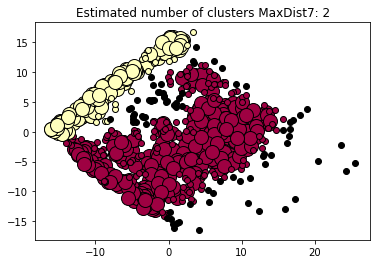

GENOTYPE
Estimated number of clusters: 3
Estimated number of noise points: 49


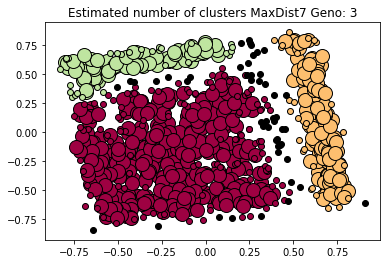

In [127]:
centroids_myversion7 = load_centroids("centroids_myversion7.dat")
data_myversion7 = np.loadtxt("archive_myversion7.dat")
fit_myversion7 = data_myversion7[:,0:1]
geno_myversion7 = data_myversion7[:, 5: 21]
all_imgs_myversion7 = []
for j in range(0, fit_myversion7.shape[0]):    
    img1 = draw(geno_myversion7[j])
    imgP1 = Image.frombuffer("RGBA",( img1.get_width(),img1.get_height() ),img1.get_data(),"raw","RGBA",0,1)
    img_arr1 = np.array(imgP1)
    flat1 = img_arr1[:,:,0].flatten()
    all_imgs_myversion7.append(flat1)    
    
all_imgs_myversion7 /= np.max(all_imgs_myversion7)
#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion7 = t_sne.fit_transform(all_imgs_myversion7)
#embed_myversion7 = embed_myversion7 / np.max(embed_myversion7)
#print(all_imgs_myversion7.shape)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_imgs_myversion7)
#print(np.min(pca_results))
#print(np.max(pca_results))
#print(pca_results)




#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion7 = t_sne.fit_transform(pca_results)
embed_myversion7 = pca_results
#embed_myversion7 /= np.max(embed_myversion7)
#print(embed_myversion7)
#embed_myversion7 = embed_myversion7 / np.max(embed_myversion7)

db = DBSCAN(eps=2, min_samples=15).fit(embed_myversion7)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_myversion7[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_myversion7[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters MaxDist7: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_MaxDist7.png', dpi=200)
plt.show()



#GENOTYPE

print("GENOTYPE")

pca = PCA(n_components=2)
pca_results_geno = pca.fit_transform(geno_myversion7)
#print(pca_results)


#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_myversion7 = t_sne.fit_transform(pca_results)
embed_myversion7_geno = pca_results_geno
#embed_myversion7_geno /= np.max(embed_myversion7_geno)
#print(embed_myversion7_geno)
#embed_myversion7 = embed_myversion7 / np.max(embed_myversion7)

db = DBSCAN(eps=0.1, min_samples=10).fit(embed_myversion7_geno)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_myversion7_geno[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_myversion7_geno[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters MaxDist7 Geno: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_MaxDist7_Geno.png', dpi=200)
plt.show()

Estimated number of clusters: 4
Estimated number of noise points: 109


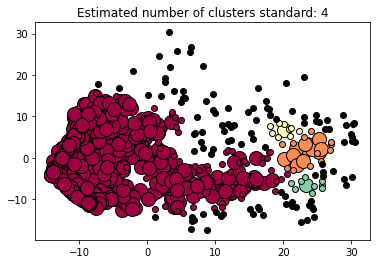

GENOTYPE
Estimated number of clusters: 2
Estimated number of noise points: 27


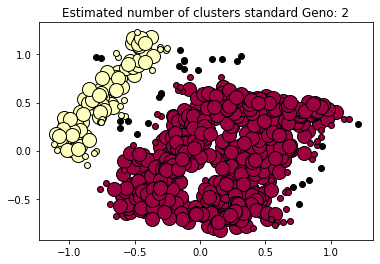

In [5]:
centroids_standard = load_centroids("centroids_standard.dat")
data_standard = np.loadtxt("archive_standard.dat")
fit_standard = data_standard[:,0:1]
geno_standard = data_standard[:, 5: 21]
all_imgs_standard = []
for j in range(0, fit_standard.shape[0]):    
    img1 = draw(geno_standard[j])
    imgP1 = Image.frombuffer("RGBA",( img1.get_width(),img1.get_height() ),img1.get_data(),"raw","RGBA",0,1)
    img_arr1 = np.array(imgP1)
    flat1 = img_arr1[:,:,0].flatten()
    all_imgs_standard.append(flat1)    
    
all_imgs_standard /= np.max(all_imgs_standard)
#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_standard = t_sne.fit_transform(all_imgs_standard)
#embed_standard = embed_standard / np.max(embed_standard)
#print(all_imgs_standard.shape)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(all_imgs_standard)
#print(np.min(pca_results))
#print(np.max(pca_results))
#print(pca_results)




#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_standard = t_sne.fit_transform(pca_results)
embed_standard = pca_results
#embed_standard /= np.max(embed_standard)
#print(embed_standard)
#embed_standard = embed_standard / np.max(embed_standard)

db = DBSCAN(eps=2.7, min_samples=10).fit(embed_standard)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_standard[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_standard[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters standard: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_Standard.png', dpi=200)
plt.show()



#GENOTYPE

print("GENOTYPE")

pca = PCA(n_components=2)
pca_results_geno = pca.fit_transform(geno_standard)
#print(pca_results)


#t_sne = TSNE(n_components = 2, metric = 'hamming')
#embed_standard = t_sne.fit_transform(pca_results)
embed_standard_geno = pca_results_geno
#embed_standard_geno /= np.max(embed_standard_geno)
#print(embed_standard_geno)
#embed_standard = embed_standard / np.max(embed_standard)

db = DBSCAN(eps=0.15, min_samples=10).fit(embed_standard_geno)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embed_standard_geno[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed_standard_geno[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters standard Geno: %d" % n_clusters_)
plt.savefig('PCA_DBSCAN_Fit_Standard_Geno.png', dpi=200)
plt.show()